In [ ]:
!pip install nxviz

# Rede 1 - Co-ocorrência de Princípios Ativos entre Medicamentos

  TIPO_PRODUTO                         NOME_PRODUTO DATA_FINALIZACAO_PROCESSO  \
0  MEDICAMENTO      (VITAMINAS A )  +  ASSSOCIACÕES                25/04/2000   
1  MEDICAMENTO   AC SALICILICO + AC BENZOICO + IODO                19/05/2000   
2  MEDICAMENTO                   ALENDRONATO SODICO                04/06/2001   
3  MEDICAMENTO                       ARNICA MONTANA                19/03/2002   
4  MEDICAMENTO                    ARNICA MONTANA L.                01/07/2002   

  CATEGORIA_REGULATORIA  NUMERO_REGISTRO_PRODUTO DATA_VENCIMENTO_REGISTRO  \
0               SIMILAR              104540166.0               01/04/2005   
1               SIMILAR              119350001.0               01/05/2005   
2               SIMILAR              100470305.0               01/05/2006   
3          FITOTERÁPICO              104730021.0               01/03/2007   
4          FITOTERÁPICO              131750004.0               01/06/2007   

   NUMERO_PROCESSO                CLASSE_TERAPEUTI

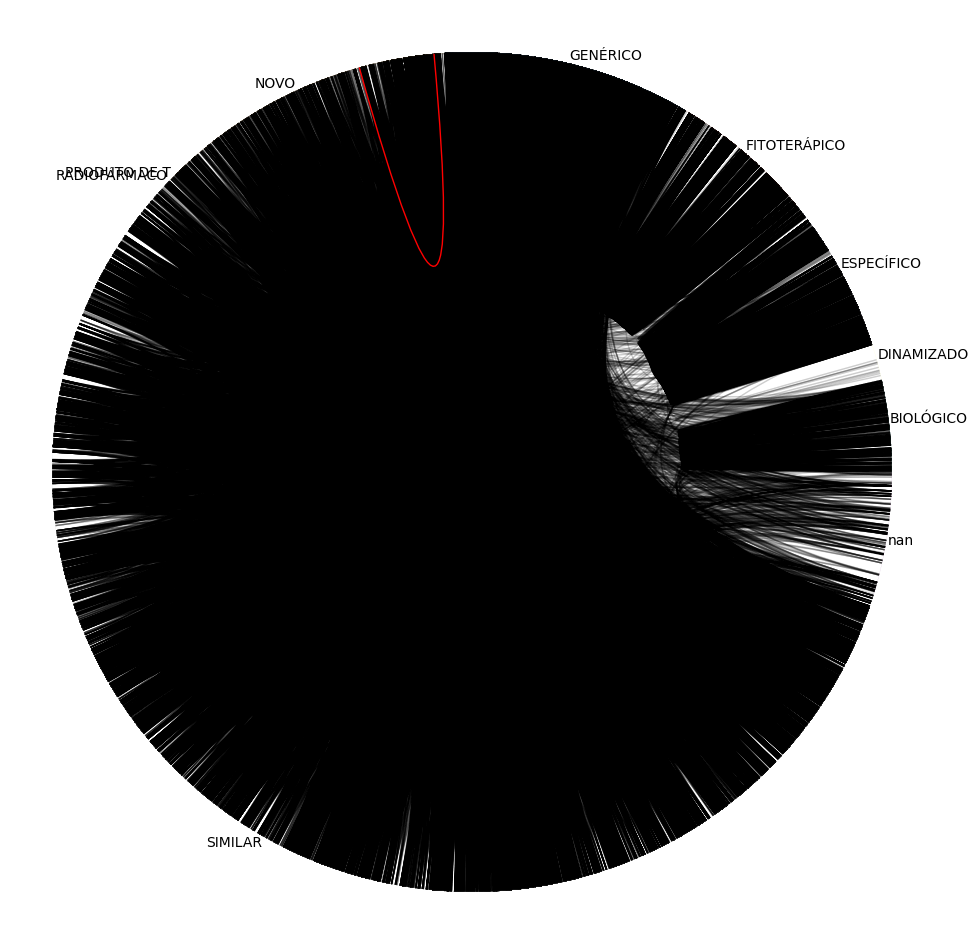

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nxviz as nv
from nxviz import annotate, highlights
from random import choice

# Carregar o CSV com encoding ISO-8859-1 e delimitador correto
df = pd.read_csv('dados.csv', encoding='ISO-8859-1', sep=';', quotechar='"', on_bad_lines='skip')

# Visualizar as primeiras linhas do dataframe
print(df.head())

# Contar medicamentos sem princípio ativo
medicamentos_sem_principio = df[df['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].nunique()
print(f"Número de medicamentos sem princípio ativo: {medicamentos_sem_principio}")

# Função para criar o grafo de co-ocorrência de princípios ativos
def criar_rede_coocorrencia_principios(df):
    G = nx.Graph()

    # Adicionar nós: Nomes dos Produtos (Medicamentos) que têm princípio ativo
    medicamentos_com_principio = df[~df['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].unique()
    G.add_nodes_from(medicamentos_com_principio)

    # Criar arestas com base em princípios ativos compartilhados
    for principio in df['PRINCIPIO_ATIVO'].dropna().unique():  # Filtra princípios ativos NaN
        # Obter lista de medicamentos que têm o mesmo princípio ativo
        meds_com_principio = df[df['PRINCIPIO_ATIVO'] == principio]['NOME_PRODUTO'].tolist()
        # Verifica se há mais de um medicamento com esse princípio ativo
        if len(meds_com_principio) > 1:
            for i in range(len(meds_com_principio)):
                for j in range(i + 1, len(meds_com_principio)):
                    G.add_edge(meds_com_principio[i], meds_com_principio[j])

    # Adicionar nós sem princípio ativo sem arestas
    medicamentos_sem_principio = df[df['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].unique()
    G.add_nodes_from(medicamentos_sem_principio)

    return G

# Criar a rede de co-ocorrência
rede_coocorrencia = criar_rede_coocorrencia_principios(df)

# Listar os nós que possuem laços
nos_com_lacos = [node for node in rede_coocorrencia.nodes() if rede_coocorrencia.has_edge(node, node)]
print("Quantos nós com laços:", len(nos_com_lacos))

# Remover laços (arestas cíclicas) do grafo
rede_coocorrencia.remove_edges_from(nx.selfloop_edges(rede_coocorrencia))

# Criar dicionário associando medicamentos à categoria regulatória
categorias = dict(zip(df['NOME_PRODUTO'], df['CATEGORIA_REGULATORIA']))

# Adicionar atributos de categoria regulatória aos nós do grafo
for node in rede_coocorrencia.nodes:
    if node in categorias:
        rede_coocorrencia.nodes[node]['categoria_regulatoria'] = str(categorias[node])

# Calcular a assortatividade com base na categoria regulatória
assortatividade_categoria = nx.attribute_assortativity_coefficient(rede_coocorrencia, 'categoria_regulatoria')
print("Assortatividade por Categoria Regulatória:", assortatividade_categoria)

# Adicionar o cálculo de assortatividade por empresa
# Criar dicionário associando medicamentos à empresa detentora do registro
empresas = dict(zip(df['NOME_PRODUTO'], df['EMPRESA_DETENTORA_REGISTRO']))

# Adicionar atributos de empresa aos nós do grafo
for node in rede_coocorrencia.nodes:
    if node in empresas:
        rede_coocorrencia.nodes[node]['empresa'] = empresas[node]

# Calcular a assortatividade com base na empresa
assortatividade_empresa = nx.attribute_assortativity_coefficient(rede_coocorrencia, 'empresa')
print("Assortatividade por Empresa:", assortatividade_empresa)

# Defina o tamanho da figura (largura, altura) em polegadas
plt.figure(figsize=(12, 12))  # Aumente os valores conforme necessário

# Circos plot para a rede de co-ocorrência com nxviz
# Criar o gráfico em formato de circos
ax = nv.circos(rede_coocorrencia,
               group_by="categoria_regulatoria",  # Agrupar por categoria regulatória
               node_color_by="categoria_regulatoria")  # Colorir nós pela categoria regulatória

# Adicionar anotações para separar os grupos
annotate.circos_group(rede_coocorrencia, group_by="categoria_regulatoria")

# Selecionar uma aresta aleatória do grafo
if rede_coocorrencia.edges:  # Verifica se existem arestas no grafo
    u, v = choice(list(rede_coocorrencia.edges()))

    # Destacar a aresta e os nós no gráfico circos
    highlights.circos_edge(rede_coocorrencia, u, v, group_by="categoria_regulatoria")
    highlights.circos_node(rede_coocorrencia, u, group_by="categoria_regulatoria")
    highlights.circos_node(rede_coocorrencia, v, group_by="categoria_regulatoria", color="blue")


# Exibir o gráfico
plt.show()

In [ ]:
# Calcular a densidade da rede
densidade = nx.density(rede_coocorrencia)
print("Densidade da Rede:", densidade)

Densidade da Rede: 0.00019694207000795554


In [ ]:
num_arestas = rede_coocorrencia.number_of_edges()
print("Número de arestas no grafo:", num_arestas)

Número de arestas no grafo: 34532


In [ ]:
# Listar os nós que possuem laços
nos_com_lacos = [node for node in rede_coocorrencia.nodes() if rede_coocorrencia.has_edge(node, node)]
print("Quantos nós com laços:", len(nos_com_lacos))

Quantos nós com laços: 0


## Grafo da rede 1 com 0,2% dos dados

      TIPO_PRODUTO             NOME_PRODUTO DATA_FINALIZACAO_PROCESSO  \
24116  MEDICAMENTO                TEVAOXALI                27/08/2007   
28030  MEDICAMENTO       diclofenaco sódico                20/02/2017   
7567   MEDICAMENTO  Cloridrato de Verapamil                11/02/2008   
22497  MEDICAMENTO                SEROPHENE                09/01/2009   
12430  MEDICAMENTO       GINSENG COMPOSITUM                13/11/2002   

      CATEGORIA_REGULATORIA  NUMERO_REGISTRO_PRODUTO DATA_VENCIMENTO_REGISTRO  \
24116               SIMILAR              155730005.0               01/08/2027   
28030                   NaN              112130487.0               01/02/2022   
7567               GENÉRICO              112130397.0               01/02/2023   
22497                   NaN              100890352.0               01/09/2019   
12430            DINAMIZADO              128420035.0               01/11/2007   

         NUMERO_PROCESSO                                 CLASSE_TERAPEUTIC

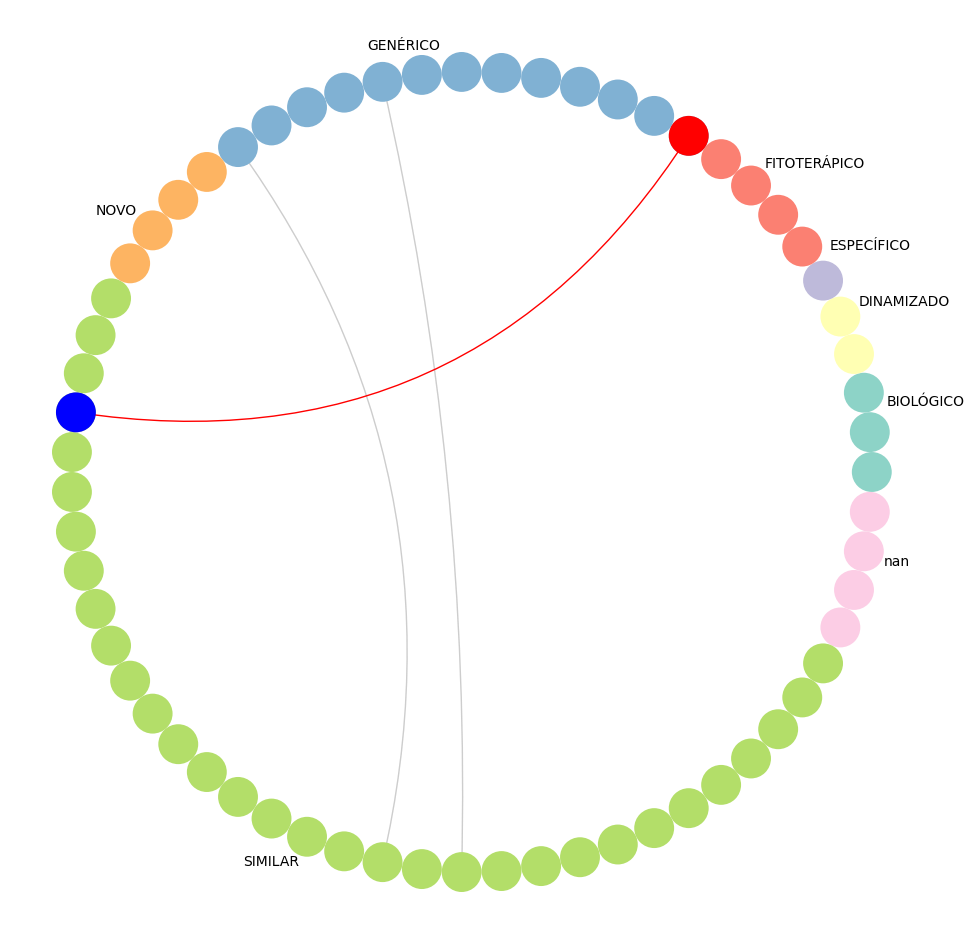

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nxviz as nv
from nxviz import annotate, highlights
from random import choice

# Carregar o CSV com encoding ISO-8859-1 e delimitador correto
df = pd.read_csv('dados.csv', encoding='ISO-8859-1', sep=';', quotechar='"', on_bad_lines='skip')

# Selecionar 0,2% dos dados aleatoriamente para teste
df_sample = df.sample(frac=0.002, random_state=42)

# Visualizar as primeiras linhas do dataframe amostrado
print(df_sample.head())

# Contar medicamentos sem princípio ativo
medicamentos_sem_principio = df_sample[df_sample['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].nunique()
print(f"Número de medicamentos sem princípio ativo: {medicamentos_sem_principio}")

# Função para criar o grafo de co-ocorrência de princípios ativos
def criar_rede_coocorrencia_principios(df):
    G = nx.Graph()

    # Adicionar nós: Nomes dos Produtos (Medicamentos) que têm princípio ativo
    medicamentos_com_principio = df[~df['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].unique()
    G.add_nodes_from(medicamentos_com_principio)

    # Criar arestas com base em princípios ativos compartilhados
    for principio in df['PRINCIPIO_ATIVO'].dropna().unique():  # Filtra princípios ativos NaN
        # Obter lista de medicamentos que têm o mesmo princípio ativo
        meds_com_principio = df[df['PRINCIPIO_ATIVO'] == principio]['NOME_PRODUTO'].tolist()
        # Verifica se há mais de um medicamento com esse princípio ativo
        if len(meds_com_principio) > 1:
            for i in range(len(meds_com_principio)):
                for j in range(i + 1, len(meds_com_principio)):
                    G.add_edge(meds_com_principio[i], meds_com_principio[j])

    # Adicionar nós sem princípio ativo sem arestas
    medicamentos_sem_principio = df[df['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].unique()
    G.add_nodes_from(medicamentos_sem_principio)

    return G

# Criar a rede de co-ocorrência com 0,2% dos dados
rede_coocorrencia = criar_rede_coocorrencia_principios(df_sample)

# Remover laços (arestas cíclicas) do grafo
rede_coocorrencia.remove_edges_from(nx.selfloop_edges(rede_coocorrencia))

# Criar dicionário associando medicamentos à categoria regulatória
categorias = dict(zip(df_sample['NOME_PRODUTO'], df_sample['CATEGORIA_REGULATORIA']))

# Adicionar atributos de categoria regulatória aos nós do grafo
for node in rede_coocorrencia.nodes:
    if node in categorias:
        rede_coocorrencia.nodes[node]['categoria_regulatoria'] = str(categorias[node])

# Calcular a assortatividade com base na categoria regulatória
assortatividade_categoria = nx.attribute_assortativity_coefficient(rede_coocorrencia, 'categoria_regulatoria')
print("Assortatividade por Categoria Regulatória:", assortatividade_categoria)

# Adicionar o cálculo de assortatividade por empresa
# Criar dicionário associando medicamentos à empresa detentora do registro
empresas = dict(zip(df_sample['NOME_PRODUTO'], df_sample['EMPRESA_DETENTORA_REGISTRO']))

# Adicionar atributos de empresa aos nós do grafo
for node in rede_coocorrencia.nodes:
    if node in empresas:
        rede_coocorrencia.nodes[node]['empresa'] = empresas[node]

# Calcular a assortatividade com base na empresa
assortatividade_empresa = nx.attribute_assortativity_coefficient(rede_coocorrencia, 'empresa')
print("Assortatividade por Empresa:", assortatividade_empresa)

# Defina o tamanho da figura (largura, altura) em polegadas
plt.figure(figsize=(12, 12))  # Aumente os valores conforme necessário

# Circos plot para a rede de co-ocorrência com nxviz
# Criar o gráfico em formato de circos
ax = nv.circos(rede_coocorrencia,
               group_by="categoria_regulatoria",  # Agrupar por categoria regulatória
               node_color_by="categoria_regulatoria")  # Colorir nós pela categoria regulatória

# Adicionar anotações para separar os grupos
annotate.circos_group(rede_coocorrencia, group_by="categoria_regulatoria")

# Selecionar uma aresta aleatória do grafo
if rede_coocorrencia.edges:  # Verifica se existem arestas no grafo
    u, v = choice(list(rede_coocorrencia.edges()))

    # Destacar a aresta e os nós no gráfico circos
    highlights.circos_edge(rede_coocorrencia, u, v, group_by="categoria_regulatoria")
    highlights.circos_node(rede_coocorrencia, u, group_by="categoria_regulatoria")
    highlights.circos_node(rede_coocorrencia, v, group_by="categoria_regulatoria", color="blue")


# Exibir o gráfico
plt.show()


# Rede 2 - Grafo Bipartido de Medicamentos e Princípios Ativos

  TIPO_PRODUTO                         NOME_PRODUTO DATA_FINALIZACAO_PROCESSO  \
0  MEDICAMENTO      (VITAMINAS A )  +  ASSSOCIACÕES                25/04/2000   
1  MEDICAMENTO   AC SALICILICO + AC BENZOICO + IODO                19/05/2000   
2  MEDICAMENTO                   ALENDRONATO SODICO                04/06/2001   
3  MEDICAMENTO                       ARNICA MONTANA                19/03/2002   
4  MEDICAMENTO                    ARNICA MONTANA L.                01/07/2002   

  CATEGORIA_REGULATORIA  NUMERO_REGISTRO_PRODUTO DATA_VENCIMENTO_REGISTRO  \
0               SIMILAR              104540166.0               01/04/2005   
1               SIMILAR              119350001.0               01/05/2005   
2               SIMILAR              100470305.0               01/05/2006   
3          FITOTERÁPICO              104730021.0               01/03/2007   
4          FITOTERÁPICO              131750004.0               01/06/2007   

   NUMERO_PROCESSO                CLASSE_TERAPEUTI

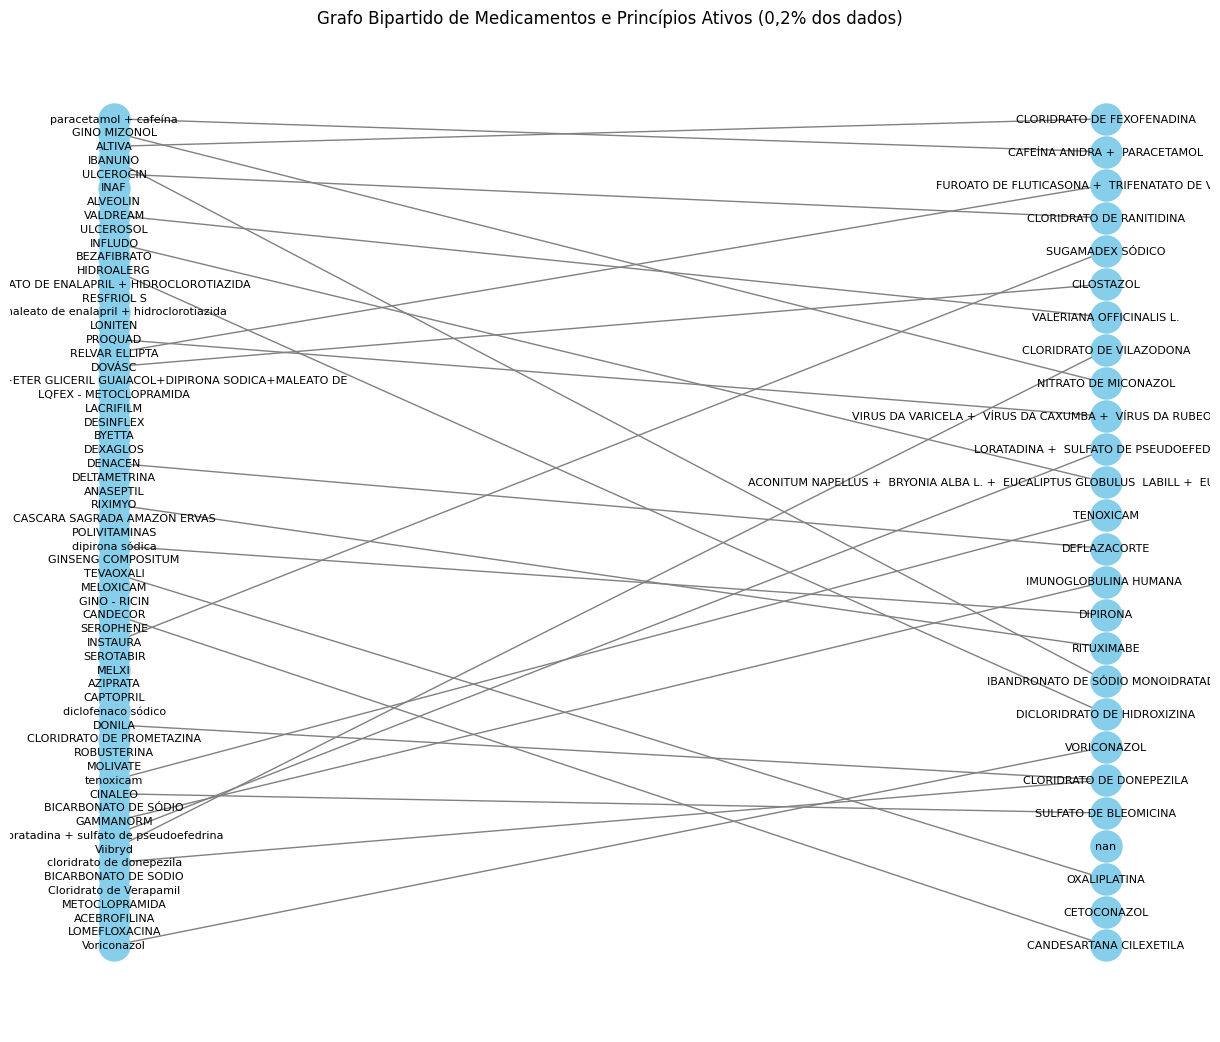

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Carregar o CSV com encoding ISO-8859-1 e delimitador correto
df = pd.read_csv('dados.csv', encoding='ISO-8859-1', sep=';', quotechar='"', on_bad_lines='skip')

# Visualizar as primeiras linhas do dataframe
print(df.head())

# Selecionar 0,2% dos dados aleatoriamente para teste
df_sample = df.sample(frac=0.002, random_state=42)

# Contar medicamentos sem princípio ativo
medicamentos_sem_principio = df_sample[df_sample['PRINCIPIO_ATIVO'].isna()]['NOME_PRODUTO'].nunique()
print(f"Número de medicamentos sem princípio ativo: {medicamentos_sem_principio}")

# Função para criar o grafo bipartido de medicamentos e princípios ativos sem arestas cíclicas
def criar_grafo_bipartido(df):
    B = nx.Graph()

    # Adicionar nós: Medicamentos e Princípios Ativos
    medicamentos = df['NOME_PRODUTO'].unique()
    principios_ativos = df['PRINCIPIO_ATIVO'].unique()

    B.add_nodes_from(medicamentos, bipartite=0)  # Tipo 0: Medicamentos
    B.add_nodes_from(principios_ativos, bipartite=1)  # Tipo 1: Princípios Ativos

    # Adicionar arestas: Medicamento -> Princípio Ativo
    for _, row in df.iterrows():
        # Somente adicionar a aresta se o princípio ativo não for NaN e for diferente do medicamento
        if not pd.isna(row['PRINCIPIO_ATIVO']) and row['NOME_PRODUTO'] != row['PRINCIPIO_ATIVO']:
            B.add_edge(row['NOME_PRODUTO'], row['PRINCIPIO_ATIVO'])

    return B

# Criar o grafo bipartido com 0,2% dos dados
grafo_bipartido = criar_grafo_bipartido(df_sample)

# Verificar se o grafo é bipartido
print(f"O grafo é bipartido? {nx.is_bipartite(grafo_bipartido)}")

# Calcular a assortatividade por grau no grafo bipartido
assortatividade_grau_bipartido = nx.degree_assortativity_coefficient(grafo_bipartido)
print("Assortatividade por grau no grafo bipartido (0,2% dos dados):", assortatividade_grau_bipartido)

# Separar os nós do grafo bipartido em dois conjuntos
medicamentos = {n for n, d in grafo_bipartido.nodes(data=True) if d.get('bipartite') == 0}
principios_ativos = set(grafo_bipartido) - medicamentos

# Visualizar o grafo bipartido com layout à esquerda (medicamentos) e à direita (princípios ativos)
plt.figure(figsize=(12, 10))
pos = nx.bipartite_layout(grafo_bipartido, medicamentos)  # Posição bipartida
nx.draw(grafo_bipartido, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=8, edge_color="gray")
plt.title("Grafo Bipartido de Medicamentos e Princípios Ativos (0,2% dos dados)")
plt.show()

## Assortatividade com 100% dos dados

In [ ]:
# Rede 02: Grafo Bipartido de Medicamentos e Princípios Ativos
def criar_grafo_bipartido(df):
    B = nx.Graph()

    # Adicionar nós: Medicamentos e Princípios Ativos
    medicamentos = df['NOME_PRODUTO'].unique()
    principios_ativos = df['PRINCIPIO_ATIVO'].unique()
    B.add_nodes_from(medicamentos, bipartite=0)
    B.add_nodes_from(principios_ativos, bipartite=1)

    # Adicionar arestas: Medicamento -> Princípio Ativo
    for _, row in df.iterrows():
        B.add_edge(row['NOME_PRODUTO'], row['PRINCIPIO_ATIVO'])

    return B

# Criar o grafo bipartido
grafo_bipartido = criar_grafo_bipartido(df)

# Calcular assortatividade por grau no grafo bipartido
assortatividade_grau_bipartido = nx.degree_assortativity_coefficient(grafo_bipartido)
print("Assortatividade por grau no grafo bipartido:", assortatividade_grau_bipartido)

Assortatividade por grau no grafo bipartido: -0.45248939108596026


# Rede 3 - Co-ocorrência por Empresa ou Classe Terapêutica

      TIPO_PRODUTO             NOME_PRODUTO DATA_FINALIZACAO_PROCESSO  \
24116  MEDICAMENTO                TEVAOXALI                27/08/2007   
28030  MEDICAMENTO       diclofenaco sódico                20/02/2017   
7567   MEDICAMENTO  Cloridrato de Verapamil                11/02/2008   
22497  MEDICAMENTO                SEROPHENE                09/01/2009   
12430  MEDICAMENTO       GINSENG COMPOSITUM                13/11/2002   

      CATEGORIA_REGULATORIA  NUMERO_REGISTRO_PRODUTO DATA_VENCIMENTO_REGISTRO  \
24116               SIMILAR              155730005.0               01/08/2027   
28030                   NaN              112130487.0               01/02/2022   
7567               GENÉRICO              112130397.0               01/02/2023   
22497                   NaN              100890352.0               01/09/2019   
12430            DINAMIZADO              128420035.0               01/11/2007   

         NUMERO_PROCESSO                                 CLASSE_TERAPEUTIC

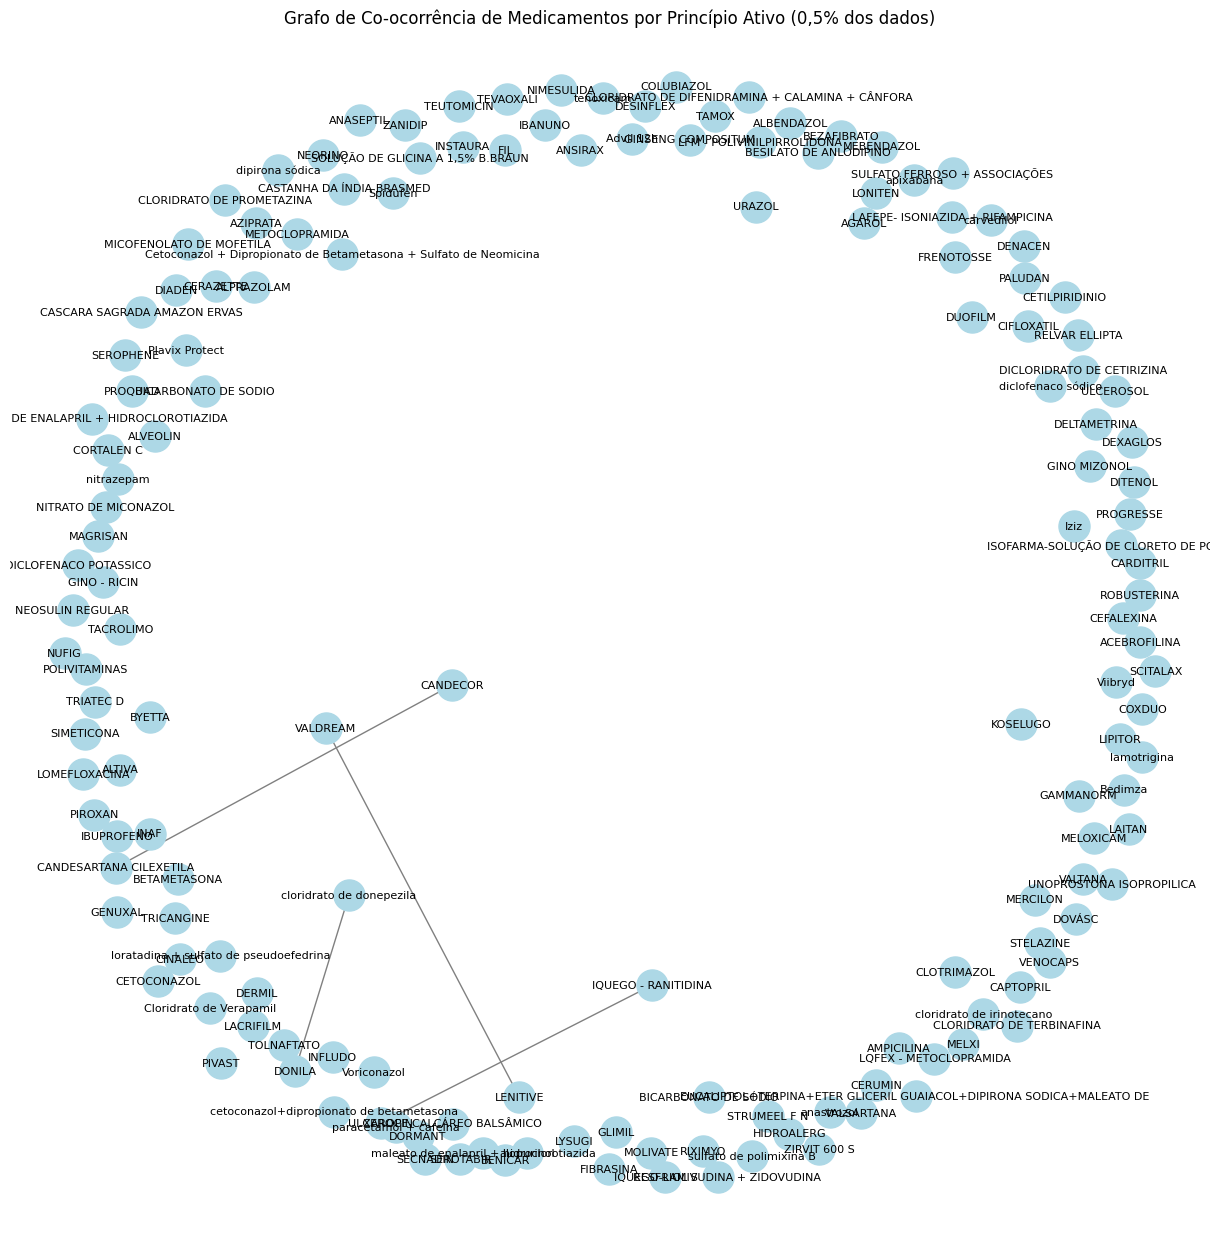

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Carregar o CSV com encoding ISO-8859-1 e delimitador correto
df = pd.read_csv('dados.csv', encoding='ISO-8859-1', sep=';', quotechar='"', on_bad_lines='skip')

# Selecionar 0,5% dos dados aleatoriamente para teste
df_sample = df.sample(frac=0.005, random_state=42)

# Visualizar as primeiras linhas do dataframe
print(df_sample.head())

# Função para criar o grafo de co-ocorrência com base em princípios ativos compartilhados
def criar_rede_coocorrencia(df):
    G = nx.Graph()

    # Adicionar nós: Medicamentos
    medicamentos = df['NOME_PRODUTO'].unique()
    G.add_nodes_from(medicamentos)

    # Criar arestas: conectar dois medicamentos se compartilharem ao menos um princípio ativo
    for principio in df['PRINCIPIO_ATIVO'].dropna().unique():
        # Obter lista de medicamentos que têm o mesmo princípio ativo
        meds_com_principio = df[df['PRINCIPIO_ATIVO'] == principio]['NOME_PRODUTO'].tolist()
        if len(meds_com_principio) > 1:  # Criar arestas somente se houver mais de um medicamento
            for i in range(len(meds_com_principio)):
                for j in range(i + 1, len(meds_com_principio)):
                    G.add_edge(meds_com_principio[i], meds_com_principio[j])

    return G

# Criar a rede de co-ocorrência de medicamentos com 0,5% dos dados
rede_coocorrencia = criar_rede_coocorrencia(df_sample)

# Remover laços (arestas cíclicas) do grafo
rede_coocorrencia.remove_edges_from(nx.selfloop_edges(rede_coocorrencia))

# Criar dicionário associando medicamentos à classe terapêutica
classes_terapeuticas = dict(zip(df_sample['NOME_PRODUTO'], df_sample['CLASSE_TERAPEUTICA']))

# Adicionar atributos de classe terapêutica aos nós do grafo
for node in rede_coocorrencia.nodes:
    if node in classes_terapeuticas:
        rede_coocorrencia.nodes[node]['classe_terapeutica'] = classes_terapeuticas[node]

# Calcular a assortatividade com base na classe terapêutica
assortatividade_classe = nx.attribute_assortativity_coefficient(rede_coocorrencia, 'classe_terapeutica')
print("Assortatividade por Classe Terapêutica (0,5% dos dados):", assortatividade_classe)

# Criar dicionário associando medicamentos à empresa detentora do registro
empresas = dict(zip(df_sample['NOME_PRODUTO'], df_sample['EMPRESA_DETENTORA_REGISTRO']))

# Adicionar atributos de empresa aos nós do grafo
for node in rede_coocorrencia.nodes:
    if node in empresas:
        rede_coocorrencia.nodes[node]['empresa'] = empresas[node]

# Calcular a assortatividade com base na empresa
assortatividade_empresa = nx.attribute_assortativity_coefficient(rede_coocorrencia, 'empresa')
print("Assortatividade por Empresa (0,5% dos dados):", assortatividade_empresa)

# Visualizar o grafo de co-ocorrência
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(rede_coocorrencia, seed=42, k=0.5)  # Layout para melhor visualização
nx.draw(rede_coocorrencia, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8, edge_color="gray")
plt.title("Grafo de Co-ocorrência de Medicamentos por Princípio Ativo (0,5% dos dados)")
plt.show()


## Assortatividade com 100% dos dados

In [ ]:
# Rede 03: Co-ocorrência por Empresa ou Classe Terapêutica
def criar_rede_coocorrencia_empresa_classe(df):
    G = nx.Graph()

    # Adicionar nós: Medicamentos
    medicamentos = df['NOME_PRODUTO'].unique()
    G.add_nodes_from(medicamentos)

    # Criar arestas com base em princípios ativos compartilhados
    for principio in df['PRINCIPIO_ATIVO'].unique():
        meds_com_principio = df[df['PRINCIPIO_ATIVO'] == principio]['NOME_PRODUTO'].tolist()
        for i in range(len(meds_com_principio)):
            for j in range(i + 1, len(meds_com_principio)):
                G.add_edge(meds_com_principio[i], meds_com_principio[j])

    return G

# Criar a rede de co-ocorrência por empresa/classe
rede_empresa_classe = criar_rede_coocorrencia_empresa_classe(df)

# Criar dicionário associando medicamentos à classe terapêutica
classes_terapeuticas = dict(zip(df['NOME_PRODUTO'], df['CLASSE_TERAPEUTICA']))

# Adicionar atributos de classe terapêutica aos nós do grafo
for node in rede_empresa_classe.nodes:
    if node in classes_terapeuticas:
        rede_empresa_classe.nodes[node]['classe_terapeutica'] = classes_terapeuticas[node]

# Calcular a assortatividade com base no atributo 'classe_terapeutica'
assortatividade_classe = nx.attribute_assortativity_coefficient(rede_empresa_classe, 'classe_terapeutica')
print("Assortatividade por Classe Terapêutica:", assortatividade_classe)


Assortatividade por Classe Terapêutica: 0.6975707077927201
